In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit, minimize
from scipy.integrate import solve_ivp, odeint
import numpy as np


# Helper Functions

In [2]:
def sir_model(t, y, beta, gamma):
    '''' y is tuple with 
    (S, I, R) - > (Voters (infuencible), Opioniated voters (voter percentage for chosen candidate), Recovered (Voters who change sides) 
    
    '''
    S, I, R = y
    dSdt = -beta * S * I # It can go both ways ? 
    dIdt = beta * S * I - gamma * I # what is the mechanism for this. What is gamma a function of ? 
    dRdt = gamma * I # potenitally, beta and gamma are funcitons of time ? 
    return [dSdt, dIdt, dRdt]

In [3]:
def fit_sir_model(t, beta, gamma, S0, I0, R0):
    '''What is the return value?'''
    sol = solve_ivp(sir_model, [t[0], t[-1]], [S0, I0, R0], t_eval=t, args=(beta, gamma))
    return sol.y[1] # returns S, I, R as they change wrt time. y[1] gives I 

In [4]:
def sir_model1(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [5]:
def sir_model2(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I  - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [6]:
def fitness_function(params, t, data_I, N):
    beta, gamma = params
    S0, I0, R0 = N - data_I[0], data_I[0], 0  # Assume S0 is total population minus initial I
    y0 = S0, I0, R0

    # Solve ODEs
    sol = odeint(sir_model1, y0, t, args=(beta, gamma, N))

    # Compute the squared error for the infected population
    I_model = sol[:, 1]  # Extract the infected population from the model
    error_I = np.sum((I_model - data_I) ** 2)

    return error_I,

In [7]:
def loss(params, t, R_data, I0=0.01):
    beta, gamma = params
    S0 = 1 - I0
    y0 = [S0, I0, 0.0]
    sol = odeint(sir_model2, y0, t, args=(beta, gamma))
    R_pred = sol[:, 2]
    return np.mean((R_pred - R_data) ** 2)

# Data Visualization

In [8]:
df = pd.read_csv("1976-2020-senate.csv")

In [9]:
df

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
0,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,SAM STEIGER,REPUBLICAN,False,total,321236,741210,False,20210114,REPUBLICAN
1,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,WM. MATHEWS FEIGHAN,INDEPENDENT,False,total,1565,741210,False,20210114,OTHER
2,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,DENNIS DECONCINI,DEMOCRAT,False,total,400334,741210,False,20210114,DEMOCRAT
3,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,ALLAN NORWITZ,LIBERTARIAN,False,total,7310,741210,False,20210114,LIBERTARIAN
4,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,BOB FIELD,INDEPENDENT,False,total,10765,741210,False,20210114,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,2020,WYOMING,WY,56,83,68,US SENATE,statewide,gen,False,UNDER VOTES,NaN,False,total,6401,278503,False,20210114,OTHER
3626,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,KELLY LOEFFLER,REPUBLICAN,False,total,2194848,4483294,True,20210114,REPUBLICAN
3627,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,RAPHAEL WARNOCK,DEMOCRAT,False,total,2288446,4483294,True,20210114,DEMOCRAT
3628,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,False,DAVID A. PERDUE,REPUBLICAN,False,total,2213979,4483241,True,20210114,REPUBLICAN


In [10]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

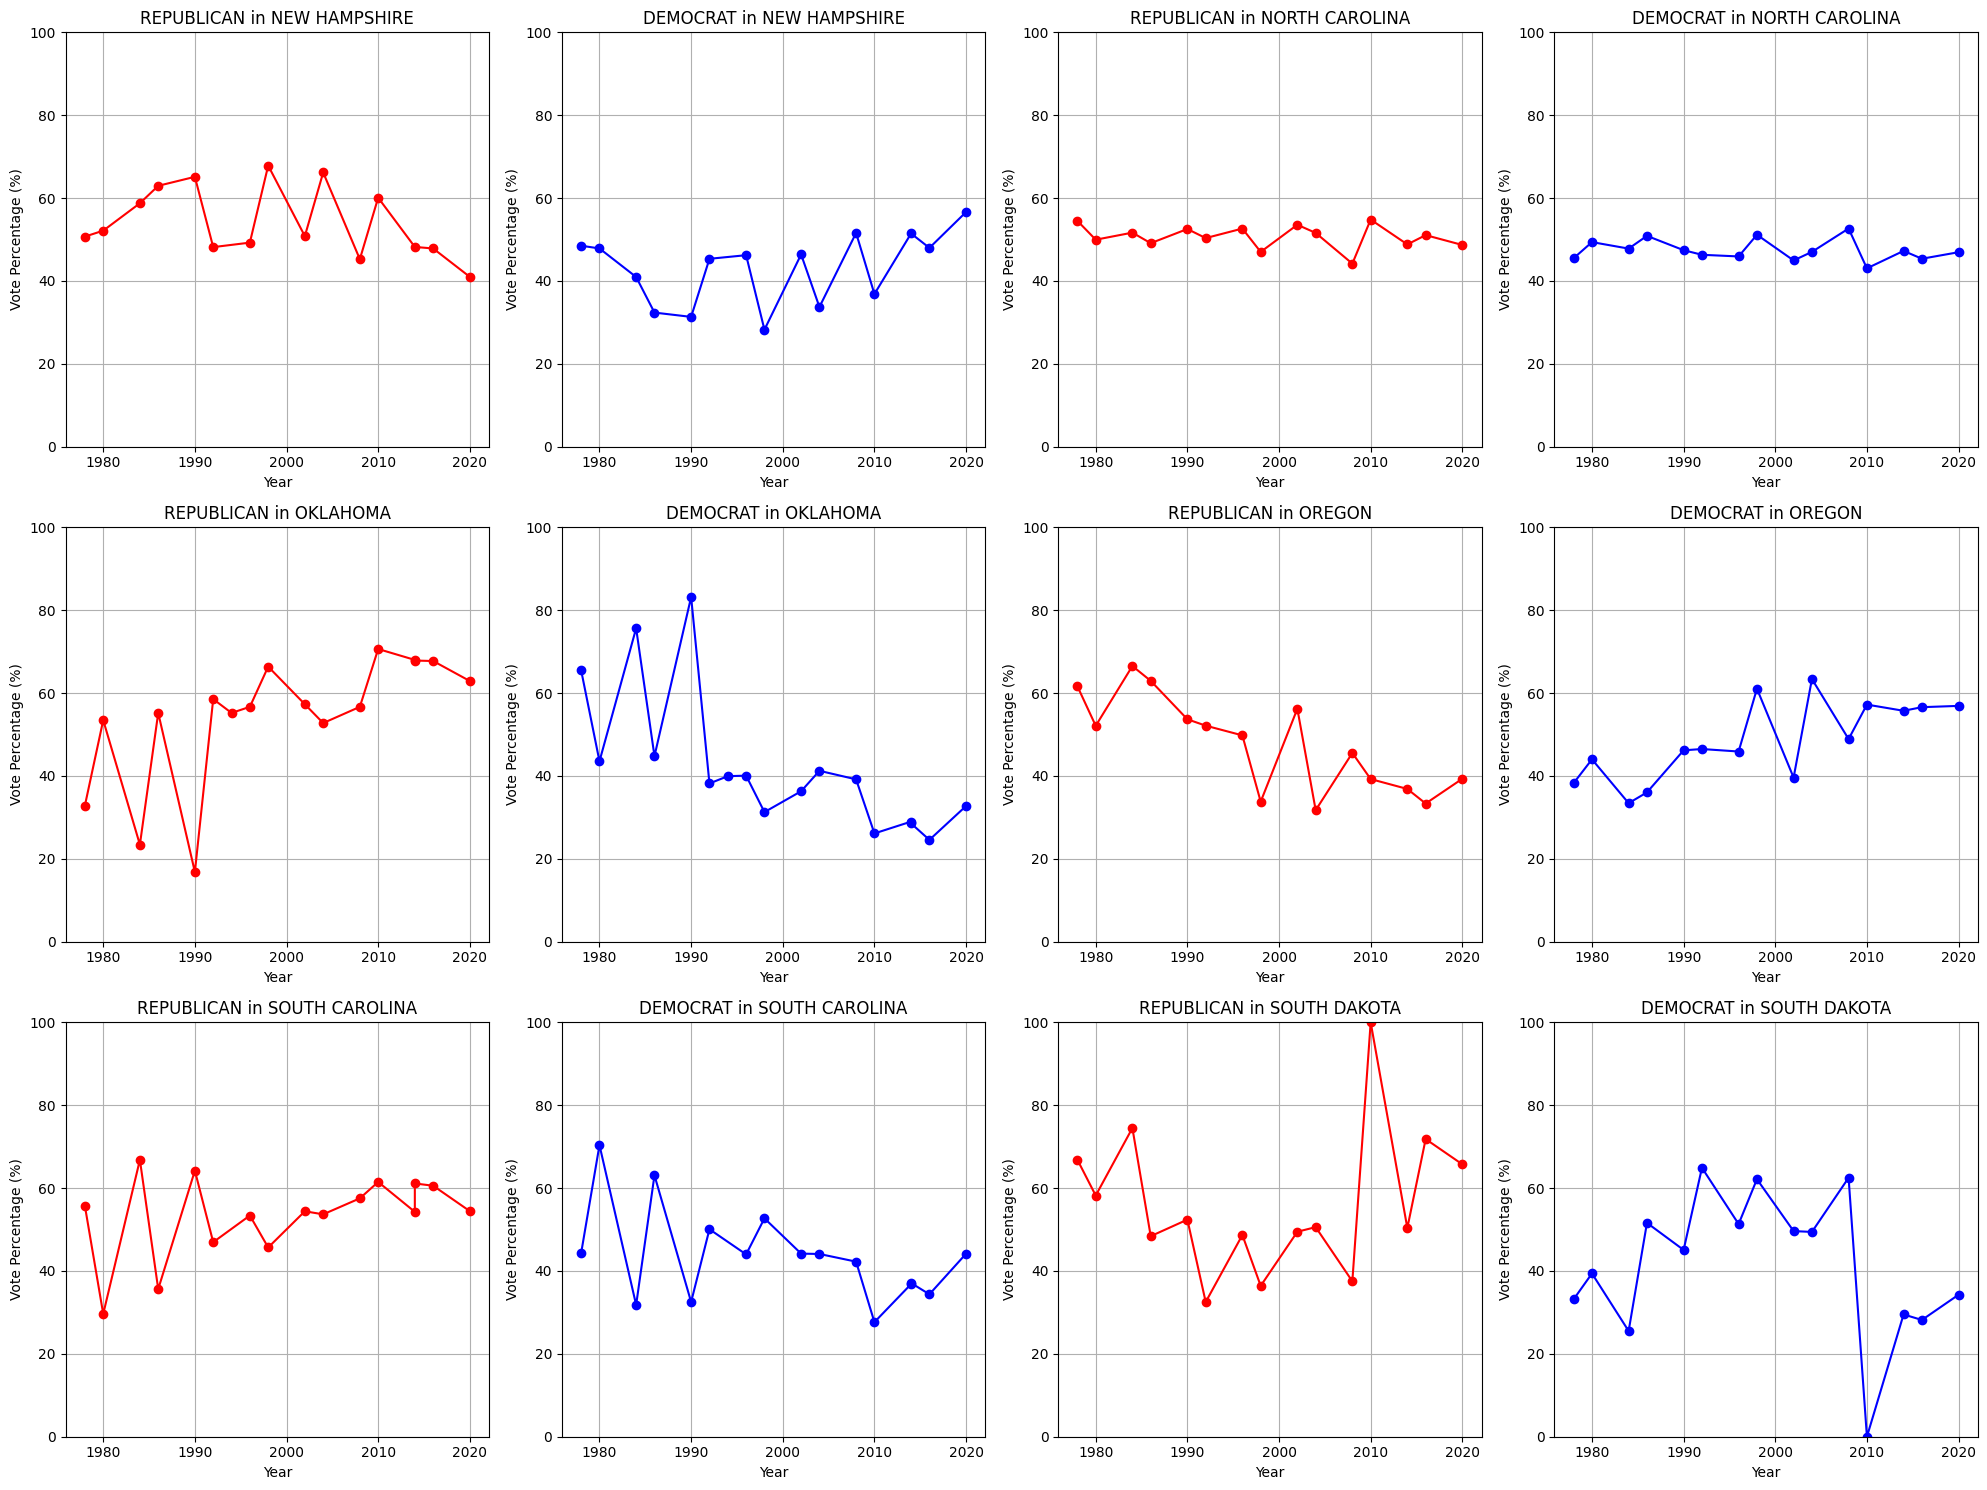

In [11]:
states = filtered_df['state'].unique()
party_order = ['REPUBLICAN', 'DEMOCRAT']
colors = {'REPUBLICAN': 'red', 'DEMOCRAT': 'blue'} # BONUS 
df_dict = {}
num_plots = len(states) * len(party_order)
cols = 4  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

plot_index = 0
for state in states:
    for party in party_order:
        state_party_data = df[(df['state'] == state) & (df['party_simplified'] == party)]
        state_party_data = state_party_data[state_party_data['writein'] == False]
        df_dict[(state, party)] = state_party_data
        if not state_party_data.empty:
            ax = axes[plot_index]
            ax.plot(state_party_data['year'], state_party_data['candidatevotes'] / state_party_data['totalvotes'] * 100, marker='o', color=colors[party])
            ax.set_title(f'{party} in {state}')
            ax.set_xlabel('Year')
            ax.set_ylabel('Vote Percentage (%)')
            ax.set_ylim(0, 100)
            ax.grid(True)
            plot_index += 1

# Hide unused subplots
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Pearson Coefficient

In [12]:
year1 = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['year'].values
votes1 = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['candidatevotes'].values
total_votes1 = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['totalvotes'].values
vote_percentage1 = votes1 / total_votes1

year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes

correlation = np.corrcoef(vote_percentage, vote_percentage1)[0, 1]
print("Pearson Correlation:", correlation)

Pearson Correlation: 0.01222907607251956


# Fitting with Least Squares

In [13]:
cols = ['year', 'candidatevotes', 'totalvotes']
df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')][cols]

,year,candidatevotes,totalvotes
221,1978,133745,263760
346,1980,195559,375060
607,1984,225828,384369
719,1986,154090,244735
956,1990,189792,291393
1100,1992,249591,518170
1415,1996,242257,491873
1568,1998,213477,314696
1905,2002,227229,447135
2059,2004,434847,657086


In [14]:
year = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['year'].values
votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.05437962006374229, gamma=0.034463992959299986


In [15]:
fitted_voter_percentage = fit_sir_model(year, *params)

In [16]:
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")
test_fit = (fit_sir_model(year, *params))


Fitted parameters: beta=0.567209945212477, gamma=0.0036562850678432427


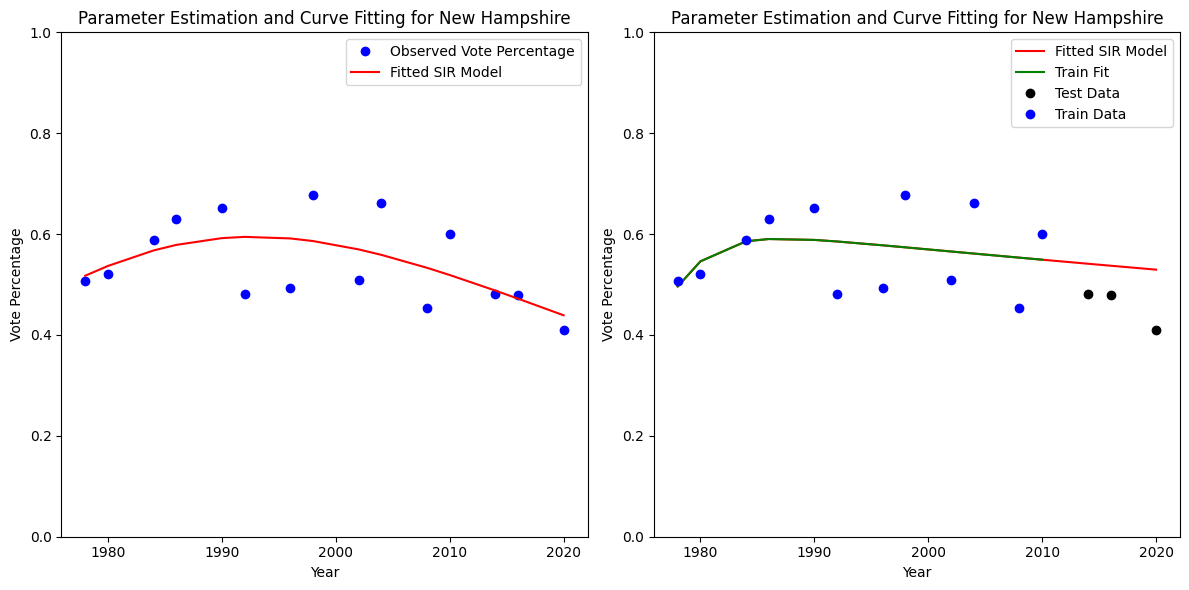

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axes[0].plot(year, vote_percentage, 'bo', label='Observed Vote Percentage')
axes[0].plot(year, fitted_voter_percentage, 'r-', label='Fitted SIR Model')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Vote Percentage')
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Second plot
axes[1].plot(year, test_fit, 'r-', label='Fitted SIR Model')
axes[1].plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
axes[1].plot(X_test, y_test, 'ko', label='Test Data')
axes[1].plot(X_train, y_train, 'bo', label='Train Data')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Vote Percentage')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## TO DO
- clean the data frame to get more data. 
- Train-test split | Cross Validate
- Get optimum parameters for different guesses. 
- Can try different estimations
- ADD MORE REALISTIC PARAMETERS TO THE MODEL 

In [18]:
year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
test_fit = (fit_sir_model(year, *params))
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.46674056035620726, gamma=0.019098885136319535


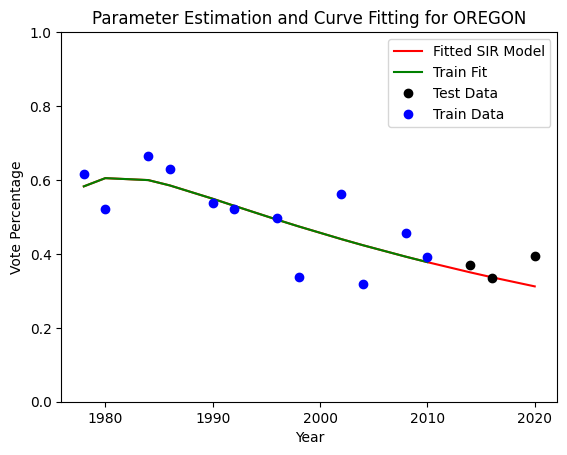

In [19]:
plt.plot(year, test_fit, 'r-', label='Fitted SIR Model')
plt.plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation and Curve Fitting for OREGON')
plt.show()

# Evolutionary algorithm

In [20]:
from deap import base, creator, tools, algorithms
import numpy as np
from scipy.integrate import odeint
import random

In [21]:
def run_ga(data_I, t, N):
    # Define the problem as a minimization problem
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize fitness
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Initialize the individual and population
    def create_individual():
        return [random.uniform(0, 1) for _ in range(2)]  # Beta and Gamma values

    # Register the components for the GA
    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", fitness_function, t=t, data_I=data_I, N=N)

    # Create the population
    population = toolbox.population(n=50)

    # Set the parameters for the genetic algorithm
    ngen = 100  # number of generations
    cxpb = 0.7  # probability of mating
    mutpb = 0.2  # probability of mutation

    # Run the genetic algorithm
    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                        stats=None, halloffame=None, verbose=True)

    # Extract the best individual (solution)
    best_individual = tools.selBest(population, 1)[0]
    return best_individual

In [22]:
N = 10000
best_params = run_ga(vote_percentage, year, N)
beta, gamma = best_params
print(f"Best parameters from GA: beta={beta}, gamma={gamma}")
ea_fit = (fit_sir_model(year, *params))

gen	nevals
0  	50    
1  	30    
2  	37    
3  	43    
4  	46    
5  	34    
6  	37    
7  	36    
8  	43    
9  	37    
10 	38    
11 	41    
12 	36    
13 	36    
14 	35    
15 	35    
16 	31    
17 	42    
18 	39    
19 	40    
20 	30    
21 	31    
22 	41    
23 	38    
24 	42    
25 	38    
26 	35    
27 	39    
28 	36    
29 	39    
30 	36    
31 	32    
32 	42    
33 	35    
34 	39    
35 	39    
36 	40    
37 	35    
38 	38    
39 	39    
40 	40    
41 	40    
42 	35    
43 	24    
44 	33    
45 	35    
46 	33    
47 	41    
48 	43    
49 	38    
50 	38    
51 	37    
52 	30    
53 	38    
54 	44    
55 	43    
56 	35    
57 	36    
58 	36    
59 	34    
60 	36    
61 	40    
62 	30    
63 	41    
64 	36    
65 	32    
66 	37    
67 	38    
68 	41    
69 	39    
70 	34    
71 	33    
72 	41    
73 	31    
74 	39    
75 	42    
76 	42    
77 	32    
78 	43    
79 	41    
80 	35    
81 	33    
82 	40    
83 	40    
84 	46    
85 	38    
86 	32    
87 	29    
88 	36    
89 	44    

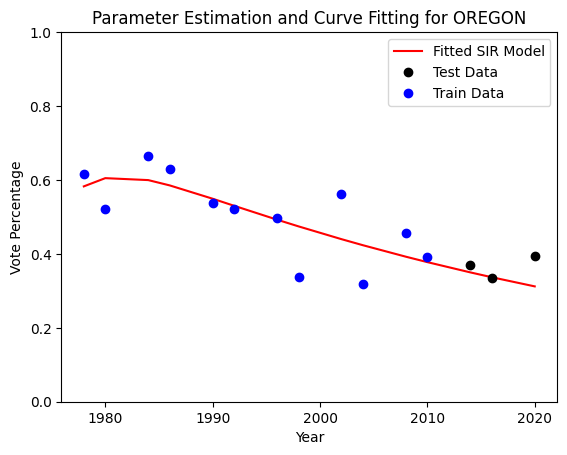

In [23]:
plt.plot(year, ea_fit, 'r-', label='Fitted SIR Model')
# plt.plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation and Curve Fitting for OREGON')
plt.show()

# Implementing sliding window parameter fitting

In [24]:
year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
M = 4
window_length  = int(len(year / M))
beta_array = np.zeros(len(year)-M+1)
gamma_array = np.zeros(len(year)-M+1)
test_fit_array = np.zeros((len(year)-M+1, M))
results = []
for i in range(len(year)-M+1):
    I0 = vote_percentage[i]
    S0 = 1 - I0
    R0 = 0
    params, covariance = curve_fit(fit_sir_model, year[i:i+M], vote_percentage[i:i+M], p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
    initial_params = [0.1, 0.1]
    res = minimize(loss, initial_params, args=(year[i:i+M], vote_percentage[i:i+M]), bounds=[(0, 2), (0, 2)])
    beta, gamma = res.x
    results.append({
        'start_year':i,
        'end_year': i+M,
        'beta': beta,
        'gamma': gamma
    })
    beta_array[i], gamma_array[i] = params[:2]
    test_fit_array[i, :] = fit_sir_model(year[i:i+M], *params)


/tmp/ipykernel_9500/2203143884.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(fit_sir_model, year[i:i+M], vote_percentage[i:i+M], p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))


In [25]:
result_df = pd.DataFrame(results)
result_df

,start_year,end_year,beta,gamma
0,0,4,2.0,0.989547
1,1,5,2.0,0.967068
2,2,6,2.0,1.180580
3,3,7,2.0,1.156685
4,4,8,2.0,1.360782
5,5,9,2.0,0.141814
6,6,10,2.0,1.338170
7,7,11,2.0,1.338139
8,8,12,2.0,1.348368
9,9,13,2.0,1.392467


In [26]:
test_fit_array = np.zeros((len(year)-M+1, M))
for i in range(len(year)-M+1):
    I0 = vote_percentage[i]
    S0 = 1 - I0
    R0 = 0
    test_fit_array[i, :] = fit_sir_model(year[i:i+M], result_df['beta'][i], result_df['gamma'][i], S0, I0, R0)

In [27]:
test_fit_array

array([[6.16418941e-01, 1.68086515e-01, 5.35080774e-03, 9.33317365e-04],
       [5.21081216e-01, 3.79605954e-02, 7.35944752e-03, 2.70420718e-04],
       [6.65290784e-01, 1.15568520e-01, 1.84867745e-03, 2.30812677e-04],
       [6.29527459e-01, 1.70693866e-02, 2.29240246e-03, 4.13303782e-05],
       [5.36813569e-01, 9.23692896e-02, 1.16939373e-03, 1.29205160e-04],
       [5.21393746e-01, 5.96570765e-01, 4.50443086e-01, 2.55565165e-01],
       [4.97956963e-01, 9.92437955e-02, 1.50042661e-03, 1.80485375e-04],
       [3.37946780e-01, 1.92690926e-02, 3.00887337e-03, 7.15030755e-05],
       [5.62085856e-01, 9.24552257e-02, 1.12958958e-03, 1.22881003e-04],
       [3.17460335e-01, 1.77199032e-02, 2.72728996e-03, 6.29889139e-05],
       [4.55534471e-01, 8.44163630e-02, 1.07565064e-03, 1.18715396e-04],
       [3.92488361e-01, 1.24449761e-02, 1.58033049e-03, 2.52021622e-05]])

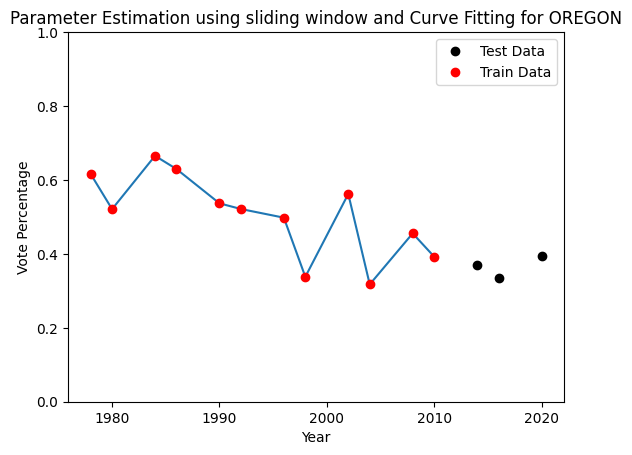

In [28]:
new = test_fit_array.T
plt.plot(year[:12], new[0])
plt.plot(X_test, y_test, 'ko', label='Test Data')

plt.plot(X_train, y_train, 'ro', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation using sliding window and Curve Fitting for OREGON')
plt.show()

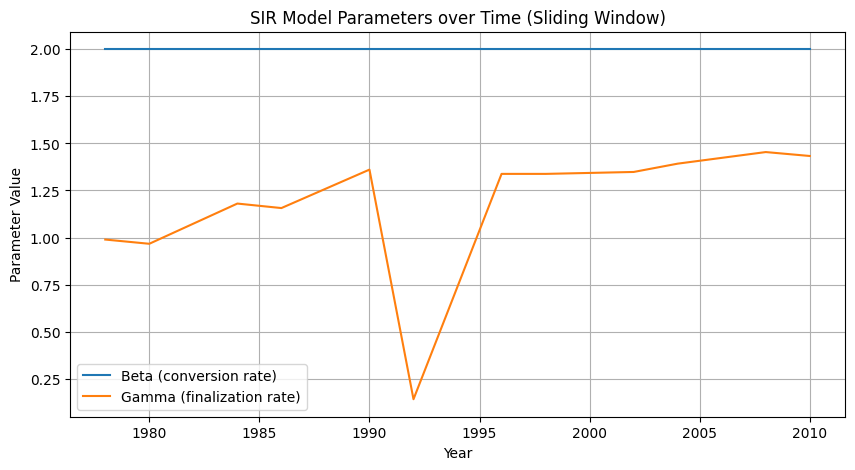

In [29]:
plt.figure(figsize=(10,5))
plt.plot(year[:len(year)-M+1], result_df['beta'], label='Beta (conversion rate)')
plt.plot(year[:len(year)-M+1], result_df['gamma'], label='Gamma (finalization rate)')
plt.xlabel('Year')
plt.ylabel('Parameter Value')
plt.title('SIR Model Parameters over Time (Sliding Window)')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
from statsmodels.tsa.arima.model import ARIMA

In [75]:
future_steps = 9
beta_vals = result_df['beta']
gamma_vals = result_df['gamma']
model_beta = ARIMA(beta_vals, order=(1, 1, 0))
results_beta = model_beta.fit()
beta_forecast = results_beta.forecast(steps=future_steps)

model_gamma = ARIMA(gamma_vals, order=(1, 1, 0))
results_gamma = model_gamma.fit()
gamma_forecast = results_gamma.forecast(steps=future_steps)

future_years = np.arange(2012, 2012 + 2*future_steps, 2)

/home/alan/bt5240/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [76]:
future_years

array([2012, 2014, 2016, 2018, 2020, 2022, 2024, 2026, 2028])

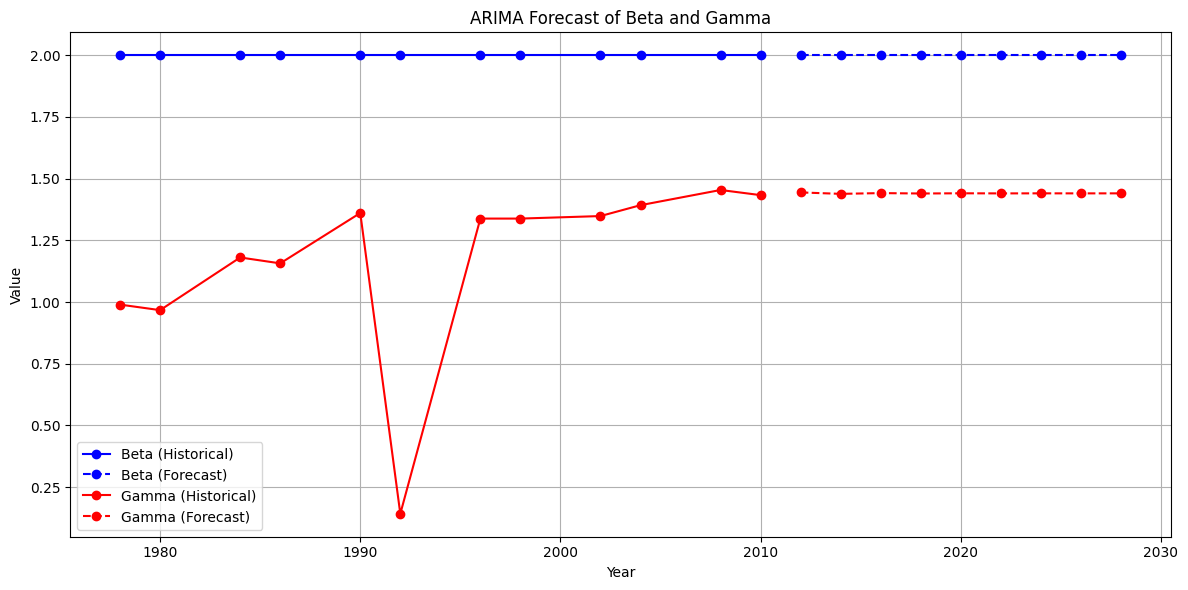

In [77]:
plt.figure(figsize=(12, 6))

# Beta plot
plt.plot(year[:len(year)-M+1], beta_vals, 'bo-', label='Beta (Historical)')
plt.plot(future_years, beta_forecast, 'b--o', label='Beta (Forecast)')

# Gamma plot
plt.plot(year[:len(year)-M+1], gamma_vals, 'ro-', label='Gamma (Historical)')
plt.plot(future_years, gamma_forecast, 'r--o', label='Gamma (Forecast)')

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("ARIMA Forecast of Beta and Gamma")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
from numpy.polynomial import Polynomial

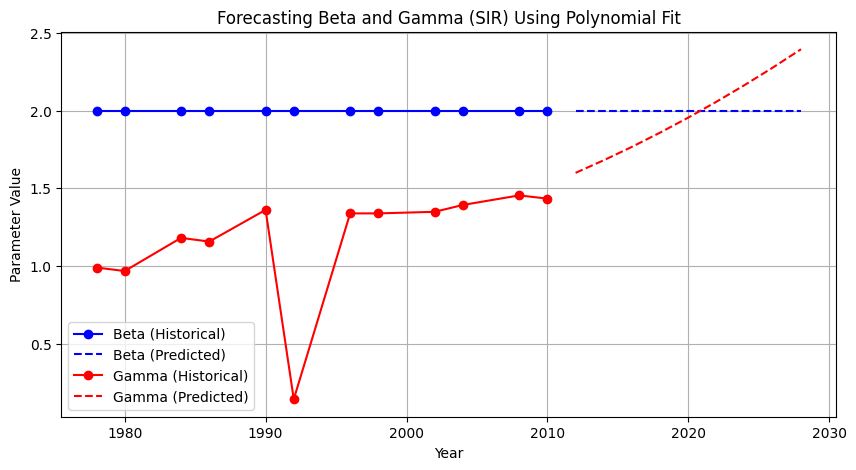

In [74]:
# Fit a degree-2 polynomial (quadratic)
beta_poly = Polynomial.fit(year[:len(year)-M+1], beta_vals, 2)
gamma_poly = Polynomial.fit(year[:len(year)-M+1], gamma_vals, 2)

# Predict for future years
future_years = np.arange(2012, 2030, 2)
beta_pred = beta_poly(future_years)
gamma_pred = gamma_poly(future_years)

# Plot
plt.figure(figsize=(10,5))
plt.plot(year[:len(year)-M+1], beta_vals, 'bo-', label='Beta (Historical)')
plt.plot(future_years, beta_pred, 'b--', label='Beta (Predicted)')
plt.plot(year[:len(year)-M+1], gamma_vals, 'ro-', label='Gamma (Historical)')
plt.plot(future_years, gamma_pred, 'r--', label='Gamma (Predicted)')
plt.xlabel("Year")
plt.ylabel("Parameter Value")
plt.title("Forecasting Beta and Gamma (SIR) Using Polynomial Fit")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
future_years[-4:]

array([2020, 2022, 2024, 2026])

In [40]:
year

array([1978, 1980, 1984, 1986, 1990, 1992, 1996, 1998, 2002, 2004, 2008,
       2010, 2014, 2016, 2020])

In [41]:
future_years

array([2012, 2014, 2016, 2018, 2020, 2022, 2024])

In [55]:
years

array([1978, 1980, 1984, 1986, 1990, 1992, 1996, 1998, 2002, 2004, 2008,
       2010, 2014, 2016, 2018, 2020, 2020, 2022, 2024])

In [79]:
beta = np.concatenate((beta_array, beta_forecast))

gamma = np.concatenate((gamma_array, gamma_forecast))
years = np.concatenate((year[:-1], future_years[-5:]))
years = np.sort(years)

test_fit_array = np.zeros((len(years)-M+1, M))

for i in range(len(years)-M):
    I0 = vote_percentage[i]
    S0 = 1 - I0
    R0 = 0
    test_fit_array[i, :] = fit_sir_model(years[i:i+M], beta[i], gamma[i], S0, I0, R0)

In [80]:
test_fit = (fit_sir_model(year, *params))


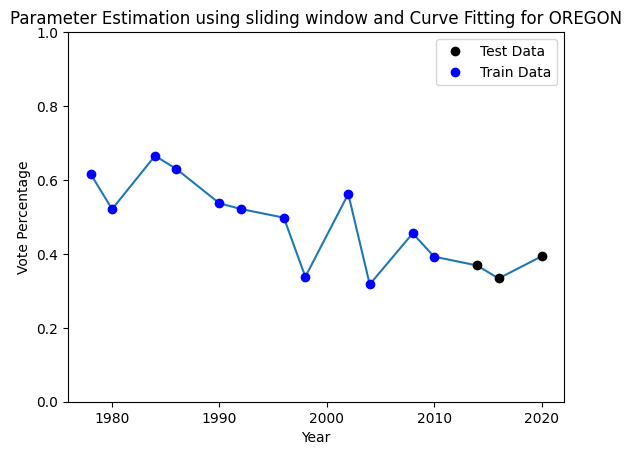

In [81]:
new = test_fit_array.T
plt.plot(years[:15], new[0][:-1])
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation using sliding window and Curve Fitting for OREGON')
plt.show()

In [82]:
beta = np.concatenate((beta_array, beta_pred))

gamma = np.concatenate((gamma_array, gamma_pred))
years = np.concatenate((year, future_years[-4:]))
test_fit_array = np.zeros((len(years)-M+1, M))

for i in range(len(years)-M):
    I0 = vote_percentage[i]
    S0 = 1 - I0
    R0 = 0
    test_fit_array[i, :] = fit_sir_model(years[i:i+M], beta[i], gamma[i], S0, I0, R0)

In [83]:
test_fit = (fit_sir_model(year, *params))

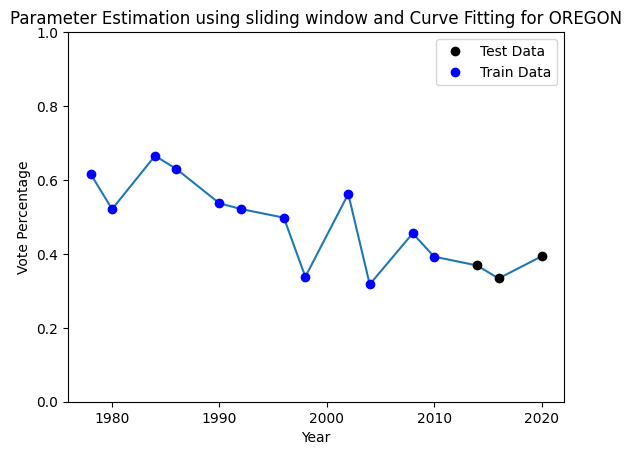

In [84]:
new = test_fit_array.T
plt.plot(years[:15], new[0][:-1])
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation using sliding window and Curve Fitting for OREGON')
plt.show()